## Topic:
Explain and visualize bias-variance tradeoff in the context of linear regression algorithm. Describe
and illustrate hyperparameter tuning for linear regression. Which hyperparameters for linear
regression you can tune in Python’s scikit-learn module and how? Relate hyperparameter tuning
and bias-variance tradeoff to cross-validation.
Explain how do you evaluate accuracy of prediction results produced by linear regression algorithm.
In your IPython example, show how to solve a prediction/forecasting problem of your choice
(select a dataset that was not used in this course) using linear regression algorithm. In addition,
explain how you have done hyperparameter tuning for your linear regression example. Visualize and
explain accuracy of your results, e.g., R2
score, mean absolute and mean squared errors, learning
curves, etc. Compute, plot and explain bias-variance tradeoff for your example

# Linear Regression with Boston Housing Prices

In [99]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#Libraries from Sci-kit Learn
from sklearn import datasets
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import GridSearchCV,cross_val_predict,cross_val_score, KFold
#Linear Regression
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn import linear_model
#Polynomial Regression:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

## Download and Explore Data

In [2]:
#Load boston dataset
boston = datasets.load_boston()

#Values
housing_prices = boston.target #target values
housing_features = boston.data #attributes values

#Store in DataFrame
attributes = boston.feature_names #feature names
df_data = pd.DataFrame(housing_features, columns = attributes)
df_target = pd.DataFrame(housing_prices, columns =['MEDV'])
df_boston = pd.concat([df_data, df_target,], axis = 1) #concat data/target
print( boston.DESCR)

print("*****************************")
print("Summary\n")
feats = df_boston.shape[1]
obs = df_boston.shape[0]
print("Number of Housing Features: ", feats)
print("Number of Houses: ", obs)


Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

In [3]:
df_boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [4]:
df_boston.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.593761,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.596783,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.647423,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


# Statistical Analysis

## Gaussian Estimation Curve of Avg House Price

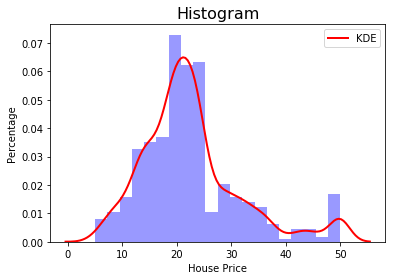

In [5]:
plt.title("Histogram",fontsize=16)
plt.xlabel('House Price')
plt.ylabel('Percentage')
sns.distplot(housing_prices, kde=True,bins=20,color='b',
             kde_kws={"color": "r", "lw": 2, "label": "KDE"})

## Scatter Plot of Target vs. Features

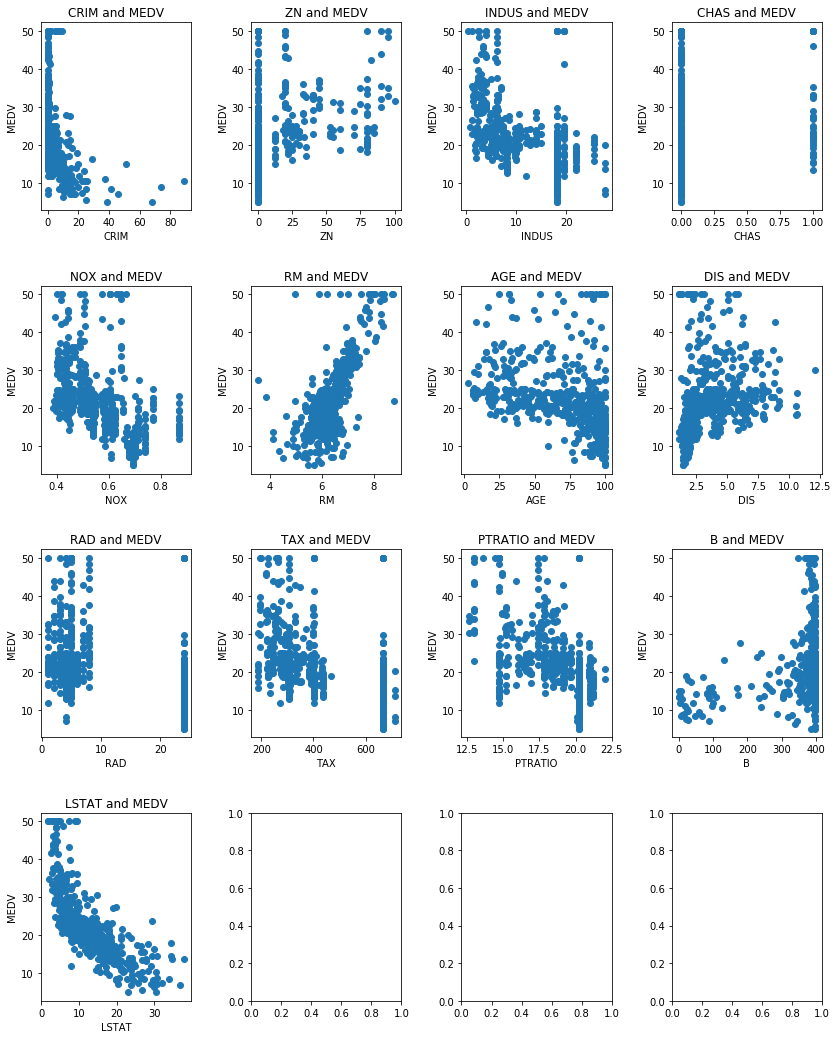

In [6]:
plt.figure()
fig,axes = plt.subplots(4, 4, figsize=(14,18))
fig.subplots_adjust(wspace=.4, hspace=.4)
img_index = 0
for i in range(boston.feature_names.size):
    row, col = i // 4, i % 4
    axes[row][col].scatter(boston.data[:,i],boston.target)
    axes[row][col].set_title(boston.feature_names[i] + ' and MEDV')
    axes[row][col].set_xlabel(boston.feature_names[i])        
    axes[row][col].set_ylabel('MEDV')
plt.show()

## Visualize Feature Correlation with Heatmap

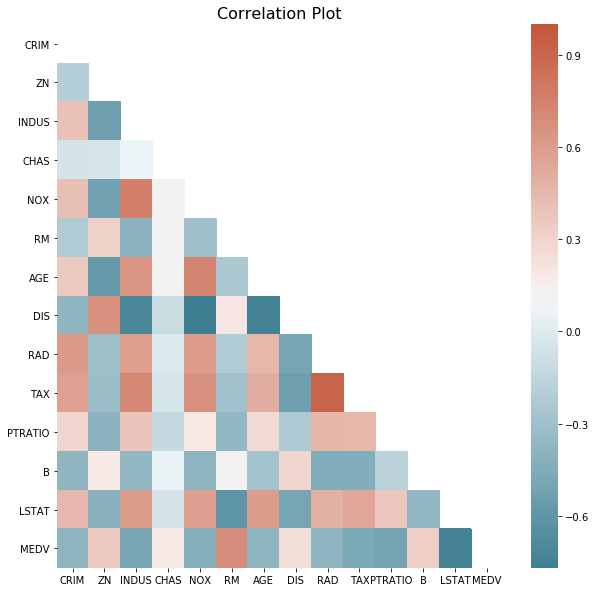

In [7]:
fig, ax = plt.subplots(figsize=(10,10))
plt.title("Correlation Plot",fontsize=16)
mask = np.zeros_like(df_boston.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(df_boston.corr(),mask=mask,cmap=sns.diverging_palette(220, 20, sep=10, as_cmap=True))

## Train-Test Split

In [8]:
# randomly split the set to train/test set with test ratio of 0.3.
X, y = boston.data, boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,random_state=42)

In [9]:
type(X)

numpy.ndarray

In [10]:
print("Size of:\nX_train: {}\ny_train: {}".format(X_test.shape,y_test.shape))

Size of:
X_train: (152, 13)
y_train: (152,)


In [11]:
print("Size of:\nX_train: {}\ny_train: {}".format(X_train.shape,y_train.shape))

Size of:
X_train: (354, 13)
y_train: (354,)


## Visualizing Learning Curve, Equation and Error

### Type of Linear Models in Sklearn:
**Baseline Model with No Regularizaiton**
- sklearn.LinearRegression()
- Can be easily overfitted on noise
- ![](http://scikit-learn.org/stable/_images/math/e8e92a5482d9327d939e7a17946a8a1b98006018.png)

**L1 Regularization Model: **
- sklearn.linear_model.Lasso()
- Sparse Model represented as ![](http://scikit-learn.org/stable/_images/math/07c30d8004d4406105b2547be4f3050048531656.png)
- Equivalent to Laplacian Prior on regression coefficient

**L2 Regularization Model**
- sklearn.linear_model.Ridge()
- Reresented as ![](http://scikit-learn.org/stable/_images/math/48dbdad39c89539c714a825c0c0d5524eb526851.png)
- Equivalent to Gaussian Prior on regression coefficient

**Other Ensemble Models Combining both L1 ans L2 Regularizaiton**

In [93]:
def linear(x_train,x_test,y_train,y_test,column_number, model="LR",plot=True):
    # Create Linear Regression Object
    if model == 'LR':
        reg = LinearRegression()
    elif model == 'L1':
        reg = Lasso()
    elif model == 'L2':
        reg = Ridge()
            
    x_train = x_train[:,5].reshape(-1,1)
    x_test = x_test[:,5].reshape(-1,1)
    reg.fit(x_train,y_train)
    pred = reg.predict(x_test)
    print("Equation of Best Fit Line:")
    print("Y = %sx + %s" % (reg.coef_,reg.intercept_))
    print("\nR Squared Error: %s" % (r2_score(pred,y_test)))
    print("\nMean Absolute Error: %.4f" % (mean_absolute_error(pred,y_test)))
    print("\nMean Square Error: %.4f" % (mean_squared_error(pred,y_test)))
    print("\nVariance(R2): %.4f" % (reg.score(x_test,y_test)))
    if plot:
        plot_linreg(x_train,x_test,y_train,pred)
        plot_compare(pred, y_test)
    return reg


def plot_compare(prediction, y):
    fig = plt.figure(figsize=(8,6))
    plt.scatter(prediction,y)
    plt.xlabel("Ground Truth")
    plt.ylabel("Prediction")
    plt.title("Prediction vs. Ground Truth")
    plt.show()

def plot_linreg(x_train,x_test,y_train,pred):
    fig = plt.figure(figsize=(8,6))
    plt.scatter(x_train, y_train, color="red", marker="o")
    plt.plot(x_test,pred,color='blue')
    ax = fig.add_subplot(1,1,1)
    ax.scatter(x_train,y_train, color="red", marker="o")
    ax.set_ylabel('MEDV (1000$)', fontsize=14)
    ax.set_xlabel('Rooms',fontsize=14)
    ax.set_title('Rooms vs MEDV', fontsize=16)
    ax.set_xlim(2,10)
    ax.set_ylim(0,60)
    plt.show()

Equation of Best Fit Line:
Y = [9.1181022]x + -34.662307438406785

R Squared Error: -0.13978574091659146

Mean Absolute Error: 4.3142

Mean Square Error: 40.3514

Variance(R2): 0.4585


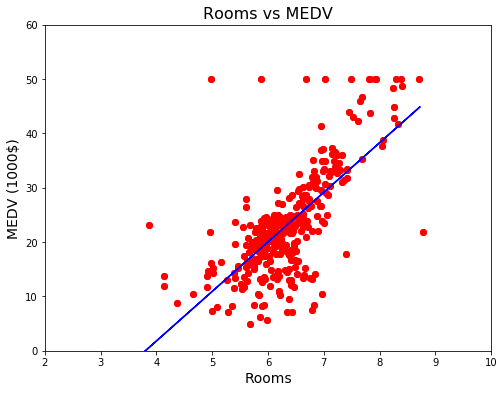

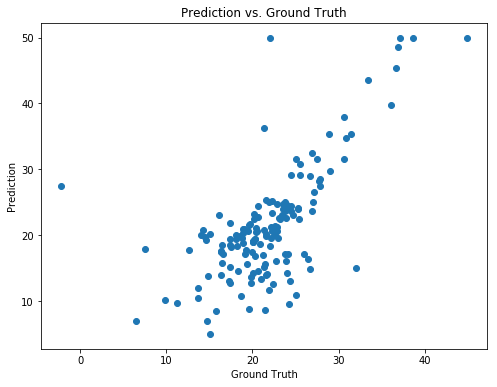

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [95]:
linear(X_train,X_test,y_train,y_test,4)

In [92]:
def linear_reg(x_train,x_test,y_train,y_test,column_number):
    # Create Linear Regression Object
    L1 = Lasso()
    L2 = Ridge()
    models = [L1,L2]
    preds = []
    x_train = x_train[:,5].reshape(-1,1)
    x_test = x_test[:,5].reshape(-1,1)
    for idx, model in enumerate(models):
        model.fit(x_train,y_train)
        preds.append(model.predict(x_test))
    plt.figure()
    plt.plot(x_test,preds[0],label='L1',color='red')
    plt.plot(x_test,preds[1],label='L2',color='yellow')
#     fig,axes = plt.subplots(1,3,figsize=(16,5))
#     for i in range(3):
#         axes[i].plot(x_test,preds[i])
#         axes[i].scatter(x_train,y_train)
    plt.scatter(x_train,y_train)
    plt.legend()
    plt.show()
    

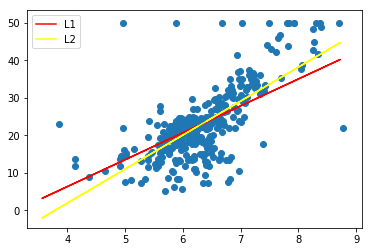

In [90]:
linear_reg(X_train,X_test,y_train,y_test,4)

## Cross-validation: Better Evaluate the Model

### Are we satisfied with the performance metric above??
# No!

### Reason:
- The train and test sets are randomly selected from the entire dataset.
- We might get extremely lucky that our one-time train/test split gives us very good fit to the data, so that to inflate the accuarcy.
<br>
OR
<br>
- We might be very unlucky that our one-time train/test split gives us worse average fit to the data, so that to decrease the accuracy.

### Solution:
Perform a K-fold cross-validation to average out the accuracy obtained from several train/test splits. In other words, reduce the vairance of our evaluation.
![](https://sebastianraschka.com/images/faq/evaluate-a-model/k-fold.png)

#### Note:
The purpose of the cross-validation is to get a more accurate evalutation of the model performance. However, if you want to do Hyperparameter selection, you should use Nested Cross-validation instead.
![](https://sebastianraschka.com/images/faq/evaluate-a-model/nested-k-fold.png)

### Nested Cross-Validation to tune hyperparameter & evaluate model

Average difference of 0.001870 with std. dev. of 0.000722.


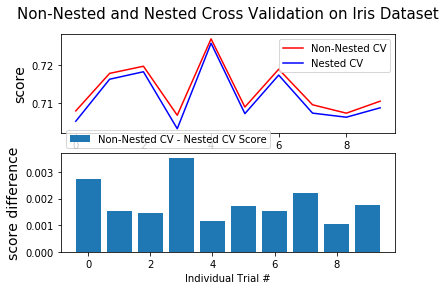

In [121]:
param_dict = {"alpha":[0.1,0.5,1,10]}
non_nested_scores = []
nested_scores = []
for i  in range(10):
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=i)
    L2 = Ridge()
    clf = GridSearchCV(L2, param_grid=param_dict,cv=inner_cv)
    # non-nested score during gridsearch
    clf.fit(X,y)
    non_nested_scores.append(clf.best_score_)
    # nested score with best gridsearch model
    nested_score = cross_val_score(L2,X,y,cv=outer_cv) 
    nested_scores.append(nested_score.mean())
nested_scores = np.array(nested_scores)
non_nested_scores = np.array(non_nested_scores)
score_difference = non_nested_scores - nested_scores

print("Average difference of {0:6f} with std. dev. of {1:6f}."
      .format(score_difference.mean(), score_difference.std()))

# Plot scores on each trial for nested and non-nested CV
plt.figure()
plt.subplot(211)
non_nested_scores_line, = plt.plot(non_nested_scores, color='r')
nested_line, = plt.plot(nested_scores, color='b')
plt.ylabel("score", fontsize="14")
plt.legend([non_nested_scores_line, nested_line],
           ["Non-Nested CV", "Nested CV"],
           loc=0)
plt.title("Non-Nested and Nested Cross Validation on Iris Dataset",
          x=.5, y=1.1, fontsize="15")

# Plot bar chart of the difference.
plt.subplot(212)
difference_plot = plt.bar(range(10), score_difference)
plt.xlabel("Individual Trial #")
plt.legend([difference_plot],
           ["Non-Nested CV - Nested CV Score"],
           bbox_to_anchor=(0, 1, .8, 0))
plt.ylabel("score difference", fontsize="14")

plt.show()

The non-nested cv scores are mostly higher than that of nested cv. Indicating that non-nested cv tends to overfit the data.

## Linear Regression with All Features

In [117]:
def multiple_reg(X_train,X_test,y_train,y_test):
    reg = Ridge()
    clf = GridSearchCV(reg,param_grid={"alpha":[0.1,0.5,1,10]})
    clf.fit(X_train,y_train)
    df = pd.DataFrame(list(zip(attributes,clf.best_estimator_.coef_)),columns=['Features','Coeff'])
    print(df)
    print('\nR-Squared: %s\n' % (round(clf.score(X_train,y_train),3)))
    
    '''Predict Housing Price:'''
    print("Let's have a look of the prediction result:\n")
    pred = clf.predict(X_test)
    df_pred = pd.DataFrame({'Observed':y_test,'Predicted':pred})
    print(df_pred.head())
    print("\nMean Squared Error: %s" % (round(mean_squared_error(pred,y_test),3)))

def main():
    multiple_reg(X_train,X_test,y_train,y_test)

if __name__ == "__main__":
    main()

   Features      Coeff
0      CRIM  -0.131803
1        ZN   0.035966
2     INDUS   0.044249
3      CHAS   3.097134
4       NOX -14.110054
5        RM   4.052959
6       AGE  -0.011937
7       DIS  -1.366369
8       RAD   0.239059
9       TAX  -0.008806
10  PTRATIO  -0.896685
11        B   0.011976
12    LSTAT  -0.550749

R-Squared: 0.743

Let's have a look of the prediction result:

   Observed  Predicted
0      23.6  28.598801
1      32.4  36.459723
2      13.6  15.311287
3      22.8  25.380215
4      16.1  18.901471

Mean Squared Error: 21.607
